# 주문건수에 영향을 미치는 요인 회귀분석

#### 왜 해야하는가? -> 라이더에게 추천하기 위해 여러 계산을 할 때 가중치를 구하기 위해서!!

In [ ]:
# 하지만 고려될 수 있는 독립변수가 너무 적다. / 고려할 수 있는 것은 주문시간대 평균금액과 평균 배달시간 뿐
# 남녀 비율과 5세단위 세대구분을 어떻게 추가할 것인가?
# 주문시간대는 int이기 때문에 단순히 증가량으로만 인식, 원핫인코딩으로 구분해야할까?

# 20대 초반 기준 데이터 전처리 / 데이터 통합!

In [18]:
import pandas as pd

# 데이터 불러오기
df_delivery = pd.read_excel('./data/delivery/서울시간별통합파일.xlsx')
df_delivery.drop('Unnamed: 0', axis=1, inplace=True)
display(df_delivery.head())

df_classify = pd.read_excel('./data/delivery/서울성별나이별구분_201907.xlsx') 
df_classify.drop('Unnamed: 0', axis=1, inplace=True)
display(df_classify.head())
# 2019년 7월부터 데이터를 불러오자, 그리고 연월까지 추출해서 유니코드로 만든 뒤 배달 데이터에 추가해야 할 듯

날짜  시간      시     구   평균시간  주문건수  평균주문금액
0  2019-07-18   0  서울특별시   구로구  22.65    16   23679
1  2019-07-18   0  서울특별시   동작구  22.17     1   15400
2  2019-07-18   0  서울특별시  영등포구  20.41    14   20864
3  2019-07-18   1  서울특별시   구로구  28.09     6   19667
4  2019-07-18   1  서울특별시  영등포구  22.19     8   18625

기준연월      시    구  5세단위구분   총인구수  남성인구수  여성인구수
0  201907  서울특별시  종로구  20-24세  10947   5251   5696
1  201908  서울특별시  종로구  20-24세  10975   5272   5703
2  201909  서울특별시  종로구  20-24세  11032   5261   5771
3  201910  서울특별시  종로구  20-24세  10990   5238   5752
4  201911  서울특별시  종로구  20-24세  10950   5201   5749

In [29]:
# 배달 데이터 전처리
import pandas as pd
import numpy as np
import re

# 전처리 참고 블로그 : https://blog.naver.com/hankrah/222085743804

# 타임테이블로 바꿔서 출력하기
df_delivery['타임테이블'] = pd.to_datetime(df_delivery['날짜'])
df_delivery['기준연월'] = df_delivery['타임테이블'].dt.to_period(freq='M')

# 기준연월을 str로 변환
df_delivery['기준연월'] = df_delivery['기준연월'].astype(str)

# 기준연월에서 '-' 제거
# df_delivery['기준연월'] = re.sub('[-=.#/?:$}]', '', df_delivery['기준연월'])
df_delivery['기준연월'] = df_delivery['기준연월'].replace('[^\d.]', '',regex=True).astype(str)

# 유니코드 만들기 -> 
df_delivery['유니코드'] = df_delivery['기준연월'] + df_delivery['구']


df_delivery.info()
display(df_delivery)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64647 entries, 0 to 64646
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      64647 non-null  object        
 1   시간      64647 non-null  int64         
 2   시       64647 non-null  object        
 3   구       64647 non-null  object        
 4   평균시간    64647 non-null  float64       
 5   주문건수    64647 non-null  int64         
 6   평균주문금액  64647 non-null  int64         
 7   타임테이블   64647 non-null  datetime64[ns]
 8   기준연월    64647 non-null  object        
 9   유니코드    64647 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 4.9+ MB


날짜  시간      시     구   평균시간  주문건수  평균주문금액      타임테이블    기준연월  \
0      2019-07-18   0  서울특별시   구로구  22.65    16   23679 2019-07-18  201907   
1      2019-07-18   0  서울특별시   동작구  22.17     1   15400 2019-07-18  201907   
2      2019-07-18   0  서울특별시  영등포구  20.41    14   20864 2019-07-18  201907   
3      2019-07-18   1  서울특별시   구로구  28.09     6   19667 2019-07-18  201907   
4      2019-07-18   1  서울특별시  영등포구  22.19     8   18625 2019-07-18  201907   
...           ...  ..    ...   ...    ...   ...     ...        ...     ...   
64642  2020-08-31  23  서울특별시   도봉구  22.76     4   30600 2020-08-31  202008   
64643  2020-08-31  23  서울특별시   양천구  24.33     8   26557 2020-08-31  202008   
64644  2020-08-31  23  서울특별시  영등포구  24.36    44   18679 2020-08-31  202008   
64645  2020-08-31  23  서울특별시   용산구  33.07     1   20900 2020-08-31  202008   
64646  2020-08-31  23  서울특별시   은평구  25.85     9   24667 2020-08-31  202008   

             유니코드  
0       201907구로구  
1       201907동작구  
2      201907영등포구  
3       201907구로구  
4      201907영등포구  
...           ...  
64642   202008도봉구  
64643   202008양천구  
64644  202008영등포구  
64645   202008용산구  
64646   202008은평구  

[64647 rows x 10 columns]

In [27]:
# 인구수 데이터 전처리
# 기준연월을 str로
df_classify['기준연월'] = df_classify['기준연월'].astype(str)

# 유니코드 만들기
df_classify['유니코드'] = df_classify['기준연월'] + df_classify['구']

display(df_classify)

기준연월      시    구  5세단위구분   총인구수  남성인구수  여성인구수       유니코드
0    201907  서울특별시  종로구  20-24세  10947   5251   5696  201907종로구
1    201908  서울특별시  종로구  20-24세  10975   5272   5703  201908종로구
2    201909  서울특별시  종로구  20-24세  11032   5261   5771  201909종로구
3    201910  서울특별시  종로구  20-24세  10990   5238   5752  201910종로구
4    201911  서울특별시  종로구  20-24세  10950   5201   5749  201911종로구
..      ...    ...  ...     ...    ...    ...    ...        ...
295  202002  서울특별시  강동구  20-24세  26616  13482  13134  202002강동구
296  202003  서울특별시  강동구  20-24세  26866  13571  13295  202003강동구
297  202004  서울특별시  강동구  20-24세  26987  13592  13395  202004강동구
298  202005  서울특별시  강동구  20-24세  26974  13570  13404  202005강동구
299  202006  서울특별시  강동구  20-24세  26980  13585  13395  202006강동구

[300 rows x 8 columns]

In [37]:
# 데이터 합쳐보기
df_EDA = pd.merge(df_delivery, df_classify, how='inner', on='유니코드')

# 필요없는 컬럼 제거
df_EDA.drop(df_EDA.columns[[7,8,9,10,11,12]], axis=1, inplace=True)

# 컬럼 이름 변경
df_EDA.rename(columns = {'시_x':'시', '구_x':'구'}, inplace=True)

# 데이터 확인
display(df_EDA)

# 데이터 저장
df_EDA.to_excel('./data/delivery/회귀분석데이터.xlsx')

날짜  시간      시     구    평균시간  주문건수  평균주문금액  5세단위구분   총인구수  \
0      2019-07-18   0  서울특별시   구로구   22.65    16   23679  20-24세  24384   
1      2019-07-18   1  서울특별시   구로구   28.09     6   19667  20-24세  24384   
2      2019-07-18   9  서울특별시   구로구   20.25     3   15167  20-24세  24384   
3      2019-07-18  10  서울특별시   구로구   21.37    21   14721  20-24세  24384   
4      2019-07-18  11  서울특별시   구로구   22.12    73   24563  20-24세  24384   
...           ...  ..    ...   ...     ...   ...     ...     ...    ...   
55610  2020-06-29  15  서울특별시  서대문구  123.20     1   29000  20-24세  23011   
55611  2020-06-29  16  서울특별시  서대문구   17.39     3   18900  20-24세  23011   
55612  2020-06-30  21  서울특별시  서대문구   91.18     1   14000  20-24세  23011   
55613  2020-06-30  22  서울특별시  서대문구   32.67     1   13700  20-24세  23011   
55614  2020-06-20  21  서울특별시   강서구   41.22     1   27500  20-24세  35114   

       남성인구수  여성인구수  
0      12039  12345  
1      12039  12345  
2      12039  12345  
3      12039  12345  
4      12039  12345  
...      ...    ...  
55610  10555  12456  
55611  10555  12456  
55612  10555  12456  
55613  10555  12456  
55614  16643  18471  

[55615 rows x 11 columns]

# ====================================================
# ====================================================
# ====================================================
# ====================================================

# 회귀분석 들어가자

In [2]:
# 모듈설치
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "./data/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
import warnings
warnings.filterwarnings("ignore")


시간    평균시간  주문건수  평균주문금액   총인구수
0       0   22.65    16   23679  24384
1       1   28.09     6   19667  24384
2       9   20.25     3   15167  24384
3      10   21.37    21   14721  24384
4      11   22.12    73   24563  24384
...    ..     ...   ...     ...    ...
55610  15  123.20     1   29000  23011
55611  16   17.39     3   18900  23011
55612  21   91.18     1   14000  23011
55613  22   32.67     1   13700  23011
55614  21   41.22     1   27500  35114

[55615 rows x 5 columns]

In [4]:
# 데이터 불러오기
df = pd.read_excel('./data/delivery/회귀분석데이터.xlsx')

# 필요없는 컬럼 unnamed:0, 날짜, 시, 구, 5세단위구분, 남성인구수, 여성인구수
df.drop(df.columns[[0,1,3,4,8,10,11]], axis=1, inplace=True)

df.columns

Index(['시간', '평균시간', '주문건수', '평균주문금액', '총인구수'], dtype='object')

In [8]:
display(df.head())
print(df.shape)

시간   평균시간  주문건수  평균주문금액   총인구수
0   0  22.65    16   23679  24384
1   1  28.09     6   19667  24384
2   9  20.25     3   15167  24384
3  10  21.37    21   14721  24384
4  11  22.12    73   24563  24384

(55615, 5)


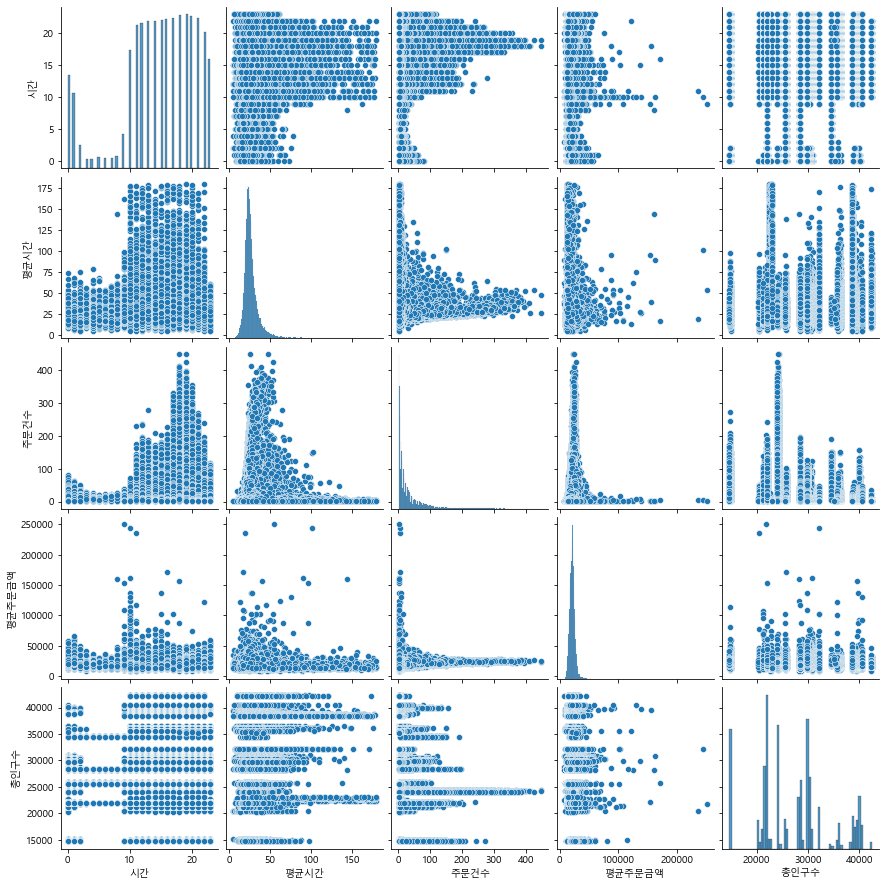

In [58]:
# 모든변수끼리 시각화

grid_df = sns.pairplot(df)
plt.show()


In [ ]:
# 약간 망스멜?

# 표준화를 진행해봅시다

In [ ]:
# 일단 표준화부터 한번 해봅시다.

In [42]:
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation이 아닌 float 모양으로 출력되게 해줍니다.
pd.options.mode.chained_assignment = None

In [10]:
# 피처 각각에 대한 scaling을 수행하는 함수를 정의합니다.
# 표준편차와 평균을 이용해 스케일링 (Z score)

def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [11]:
# 피처 각각에 대한 scaling을 수행합니다.
scale_columns = ['평균시간', '평균주문금액', '총인구수']
re_df = standard_scaling(df, scale_columns)

In [12]:
re_df = re_df.rename(columns={'주문건수': 'y'})
re_df.head(5)

시간      평균시간   y    평균주문금액     총인구수
0   0 -0.399011  16  0.399378 -0.37888
1   1 -0.027347   6 -0.334507 -0.37888
2   9 -0.562980   3 -1.157660 -0.37888
3  10 -0.486461  21 -1.239243 -0.37888
4  11 -0.435221  73  0.561082 -0.37888

In [15]:
# 시간 피처를 one-hot encoding으로 변환 --> 범주형이기 때문
time_encoding = pd.get_dummies(re_df['시간'])
re_df = re_df.drop('시간', axis=1)
re_df = re_df.join(time_encoding) # 컬럼은 많아지지만 더 효율적으로 분석 가능

KeyError: '시간'

In [ ]:
time_encoding.head(5)

In [49]:
# 주희 코드

# # module import!
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# from sklearn.model_selection import train_test_split

# # 데이터 불러오기
# df = pd.read_excel('./data/delivery/회귀분석데이터.xlsx')
# df.drop(df.columns[[0,1,3,4,8,10,11]], axis=1, inplace=True)
# df.info()


# feature_columns = df.columns.difference(["주문건수"]) # Target column 

# X = df[feature_columns]
# y = df.주문건수

# train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3)

# print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)


# # train & 회귀모델 적합, 모든 변수를 때려넣었다.

# # 회귀분석을 위해 for b0, 상수항 추가
# train_x_ = sm.add_constant(train_x, has_constant = "add")

# full_model = sm.OLS(train_y, train_x_)
# fitted_full_model = full_model.fit()

# fitted_full_model.summary()

(38930, 4) (16685, 4) (38930,) (16685,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   주문건수   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     1978.
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:42:16   Log-Likelihood:            -2.0060e+05
No. Observations:               38930   AIC:                         4.012e+05
Df Residuals:                   38925   BIC:                         4.012e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.0088      1.385     26.728      0.000      34.295      39.723
시간             1.8937      0.036     52.556      0.000       1.823       1.964
총인구수          -0.0020   3.07e-05    -64.917      0.000      -0.002      -0.002
평균시간           0.0713      0.015      4.785      0.000       0.042       0.101
평균주문금액         0.0009   3.98e-05     21.670      0.000       0.001       0.001
==============================================================================
Omnibus:                    25875.129   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           377816.157
Skew:                           3.050   Prob(JB):                         0.00
Kurtosis:                      16.990   Cond. No.                     2.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""